In [34]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random
Random.seed!(123)

include("relevant_slepian_alpha.jl")

get_quadrature_nodes_2D (generic function with 3 methods)

In [35]:
""" 
    interp2(z, xy, z0)

# Arguments
- `z::Vector` vector of z's
- `yx::Matrix` y, x coordinates at each of the z's
- `z0<:Number` level at which to interpolate z0

# Outputs
- zyx coordinates corresponding to level z0

"""
interp2(z::Vector, yx::Matrix, z0 = 0.0) = (yx[2,:] - yx[1,:])*(z0 - z[1])/(z[2] - z[1]) .+ yx[1,:]


# To get the closed curve at the level th, take the 100 points before and 100 points after 
# the crossing and interpolate each yx
"""
    interpcontour(z, z0, thph, N)

# Arguments
- `z::Vector` the two z-values between which the level z0 falls. 
- `z0<:Number` the z-level of the desired contour
- `thph::Matrix` the zyx coordinates (first N are at level z[1] second are at level z[2])
- `N::Int64` number of points for each contour
"""
function interpcontour(z, z0, thph, N)
    newcurve = map(i -> interp2(z, thph[[i, i + N],:], z0), 1:N) 
    return hcat(newcurve...)'
end


interpcontour

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)
- each contour has the same number of points, N

We will just stack a bunch of blobs.

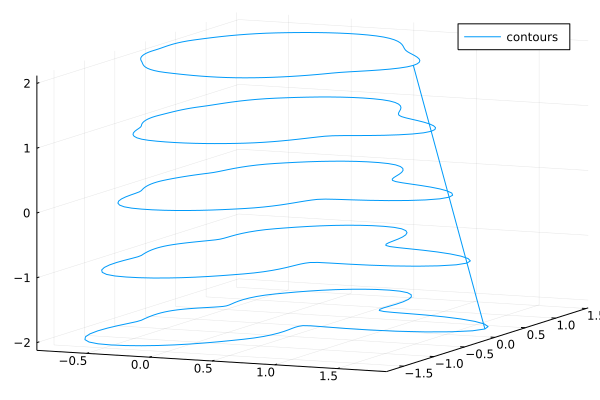

In [36]:
Nz = 5
x, y = blob(Nz,5)
N = 100
z = collect(-2:2)

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
thph = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)

# println(size(thph))
thph = vcat(thph...)
# This is necessary to close the curve
thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [37]:
Nqx = Nqy = 16
Nqz = 10

# Calculate blanks, z-axis GL points regardless of the data range
qz, wqz = FastGaussQuadrature.gausslegendre(Nqz)

mn, mx = (minimum(z), maximum(z))
# Scale the z-quadrature points to the min-max interval
th = qz*(abs(mx - mn)/2) .+ (mx + mn)/2;

# We need to find the two z's between which each quadrature point (th) lives
xmth = repeat(thph[:,1], 1, length(th)) .- repeat(th', length(thph[:,1]), 1)
dsx = diff(sign.(xmth), dims = 1)
col = findall(x -> (x == 2), dsx)
colf = map(c -> Tuple(c)[1], col)

10-element Vector{Int64}:
 100
 100
 100
 200
 200
 300
 300
 400
 400
 400

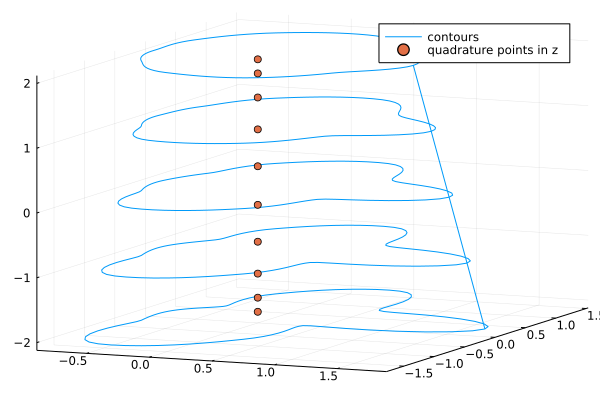

In [38]:
p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")


## Fill the quadrature nodes at each level

Get the (x,y) values at each quadrature level z, and fill the closed curve of (x,y)'s with nodes. 

In [39]:
newcurve = map(i->interpcontour(thph[colf[i]:(colf[i]+1),1], th[i], thph[(colf[i]-N+1):(colf[i]+N),:], N), 1:length(th))
pkg = map(nc -> get_quadrature_nodes_2D(nc[:,3], nc[:,2]), newcurve);
# QX, QY, w, Nrun = pkg[1]


In [40]:
pkg[1][1][1:5], pkg[2][1][1:5] 

([-0.38152234308162764, -0.3810928202032214, -0.3803242857704409, -0.3792237427995738, -0.37780144553399747], [-0.3721406226646839, -0.37169217871034543, -0.3708897892745135, -0.3697407658660137, -0.36825581444180444])

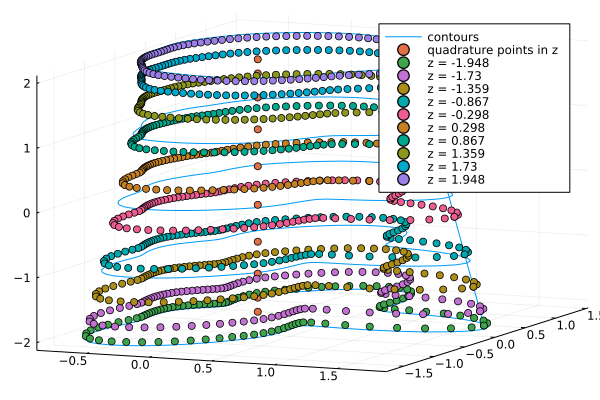

In [41]:
for i = 1:length(th)
    scatter!(p, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p

To make sure everything is going right, we plot in 2D the quadrature nodes we are getting at each level.

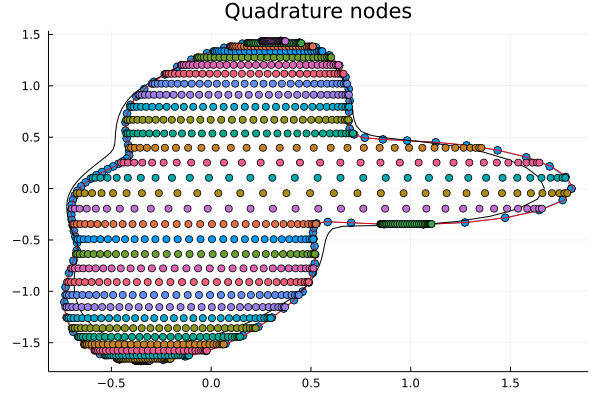

In [42]:
i = 1

q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")
plot!(q, thph[(colf[i]-N+1):(colf[i]), 3], thph[(colf[i]-N+1):(colf[i]), 2], label = "z = $(thph[colf[i]-N+1,1])", c = :red)
plot!(q, thph[(colf[i]+1):(colf[i]+N), 3], thph[(colf[i]+1):(colf[i]+N), 2], label = "z = $(thph[colf[i] + 1,1])", c = :black)

#=
ps = scatter(pkg[i][2], pkg[i][1], legend = false, title = "Quadrature nodes")

plot(q, ps, layout = (1,2))
=#

scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")

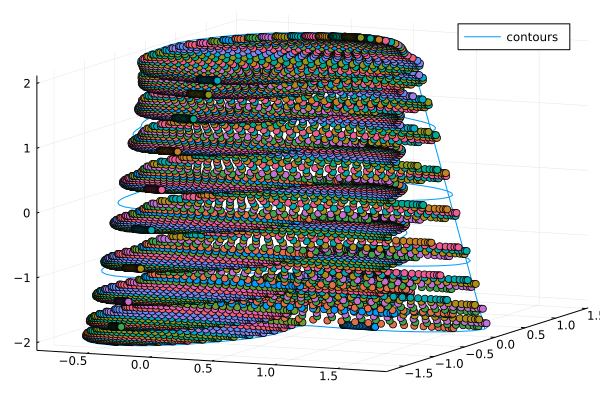

In [46]:
p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours");
for i = 1:10
    scatter!(p, pkg[i][1], pkg[i][2], ones(32,33)*th[i] , label = "")
end
p

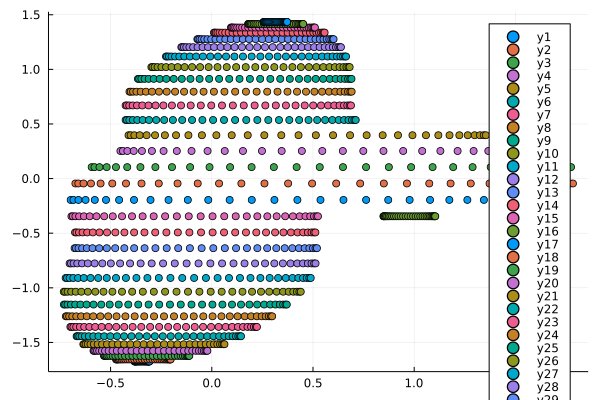

In [45]:
scatter(pkg[1][1], pkg[1][2])